# FRUIT INSPECTION

Software system aimed at locating defects and imperfections on fruits. 

Each fruit is acquired through a NIR (Near Infra-Red) and a color camera with little parallax effect.

#### Imported libraries

In [1]:
#libraries
import cv2
import numpy as np
import utils as ut
from scipy import stats
from matplotlib import pyplot as plt

#images paths
path1 = 'fruit-inspection-images/first task/'
path2 = 'fruit-inspection-images/second task/'
path3 = 'fruit-inspection-images/final challenge/'
path_samples = 'fruit-inspection-images/russet samples/'

#erosion kernel
kernel = np.ones((3,3),np.uint8)

# FIRST TASK: FRUIT SEGMENTATION AND DEFECT DETECTION

Two main parts:

1. Outline the fruit by generating a binary mask

2. Search for the defects on each fruit


#### Read images and images overview

<Figure size 640x480 with 0 Axes>

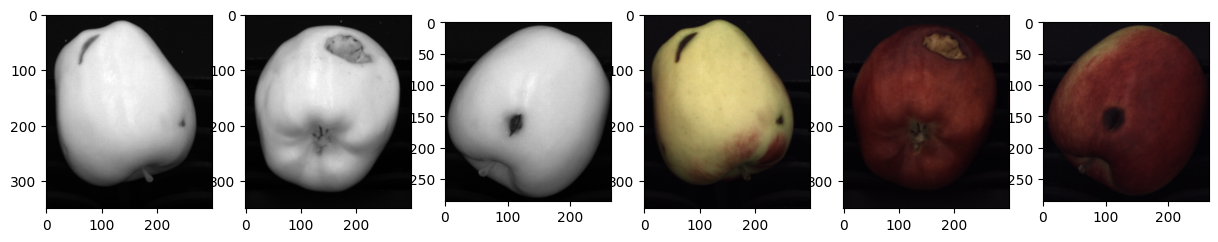

In [2]:
#create lists with the names of the images file
gray_img_names = [f'C0_00000{i}.png' for i in range(1, 4)]
colored_img_names = [f'C1_00000{i}.png' for i in range(1, 4)]

#create lists of the images (gray and colored version)
gray_images = [cv2.cvtColor(cv2.imread(path1 + name), cv2.COLOR_BGR2GRAY) for name in gray_img_names]
colored_images = [cv2.cvtColor(cv2.imread(path1 + name), cv2.COLOR_BGR2RGB) for name in colored_img_names]

all_images = gray_images + colored_images

ut.visualize_imgs_array(all_images)

## Outline the fruit by generating a binary mask

To isolate the fruits, first I blur the images to remove the small details, then I do a binarization using a fixed threshold. At the end I apply a label to each connected component to create the final fruit mask, this is done using the connected components with the bigger area because it corresponds with the fruit.
In the end, to improve the masks, I filled the holes using a flood-fill approach (how as suggested).

<Figure size 640x480 with 0 Axes>

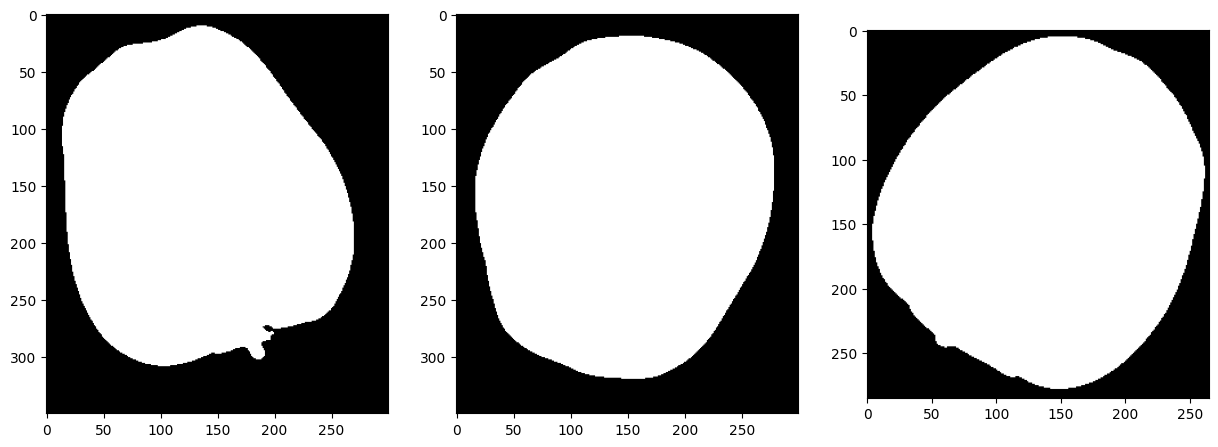

In [3]:
#blur the images with a gaussian filter
blurred_images = [cv2.GaussianBlur(image, (7, 7), 0) for image in gray_images]

#threshold the images
threshold_images = [cv2.threshold(image, 38.4, 255, cv2.THRESH_BINARY)[1] for image in blurred_images]

#labeling of the connected components
analysis = [cv2.connectedComponentsWithStats(image, 4, cv2.CV_32S) for image in threshold_images]

#create masks
masks = ut.create_masks(analysis, threshold_images)

#fill the holes in the masks
filled = [ut.fillhole(masks[i]) for i in range(len(masks))]

all_filled = filled + filled

ut.visualize_imgs_array(filled)

#### Isolate the fruits

Apply the mask to the images. 
Final results:

<Figure size 640x480 with 0 Axes>

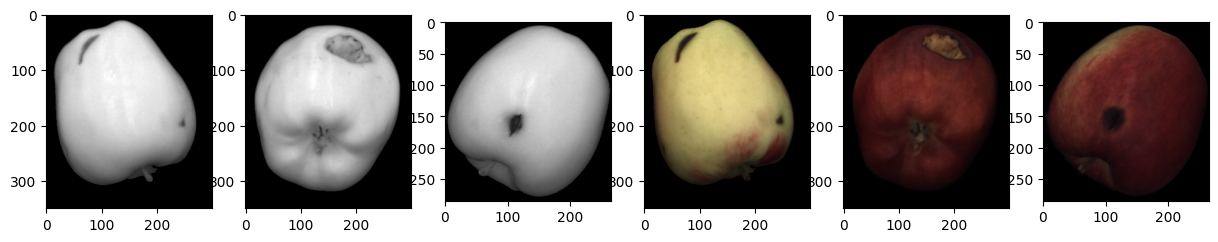

In [4]:
#apply the mask to the corresponding fruit
isolate_fruits = [cv2.bitwise_and(all_images[i], all_images[i], mask=all_filled[i]) for i in range(2*len(masks))]

ut.visualize_imgs_array(isolate_fruits)

## Search for the defects on each fruit

I use Canny edge detector to localize the contours of the defects and show the results.

<Figure size 640x480 with 0 Axes>

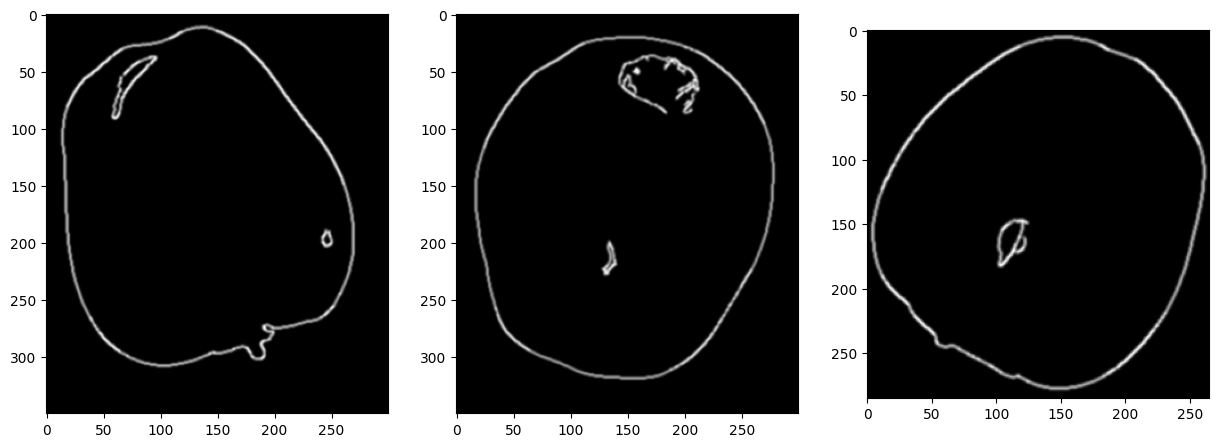

In [5]:
#apply an edge detector
edges = [cv2.Canny(isolate_fruits[i],70,200) for i in range(3)]

#blur the images with a gaussian filter
smooth_edges = [cv2.GaussianBlur(e,(5,5),0) for e in edges]

ut.visualize_imgs_array(smooth_edges)

#### Compute the mask for each defect
I label each defect, then compute a mask for each of them and then fill all the masks (same procedure as before). Show the results:

<Figure size 640x480 with 0 Axes>

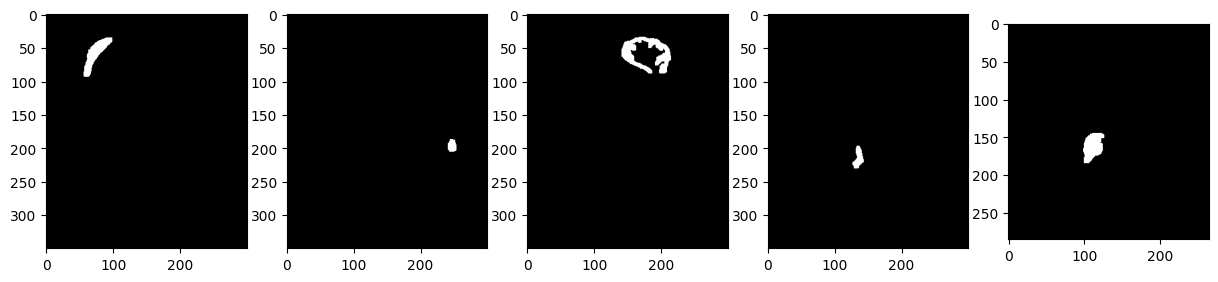

In [6]:
#labeling of each defect
defects_analysis = [cv2.connectedComponentsWithStats(e, 4, cv2.CV_32S) for e in smooth_edges]

#create masks
defects_masks = ut.create_defects_masks(defects_analysis, smooth_edges, 200, 3000)

defects_filled = [[] for i in range(len(defects_masks))]

#fill the holes in the masks
for i in  range(len(defects_masks)):
    defects_filled[i] = [ut.fillhole(defects_masks[i][j]) for j in range(len(defects_masks[i]))]

all_defects = []
for i in range(len(defects_filled)):
    all_defects = all_defects + defects_filled[i]

ut.visualize_imgs_array(all_defects)

### Final results
I compute the bounding box of each defect given the masks.

<Figure size 640x480 with 0 Axes>

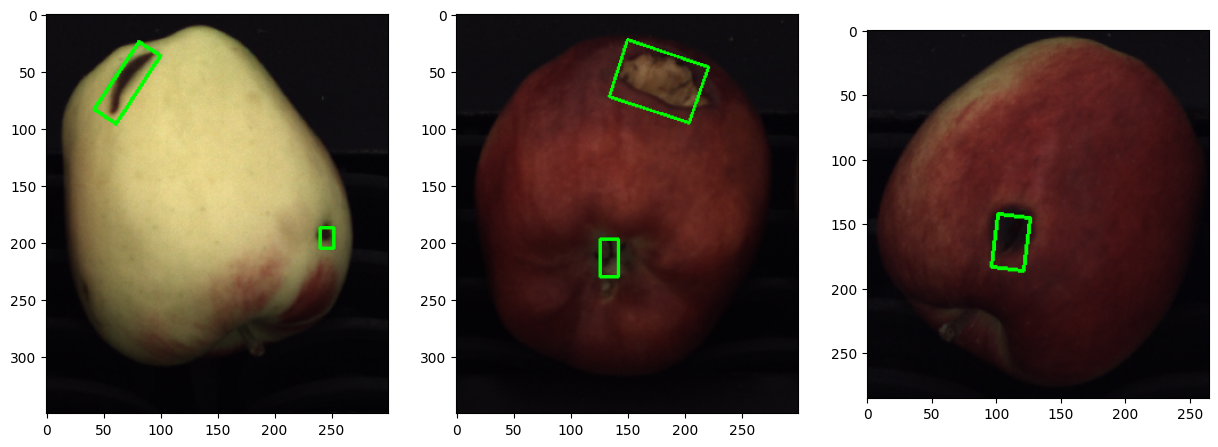

In [7]:
#compute the bounding boxes and shows the ìm on the images
rect = ut.get_bbox(defects_filled, colored_images)

ut.visualize_imgs_array(rect)

# SECOND TASK: RUSSET DETECTION

Identify the russet or at least some part of it with no false positive areas (if possible), to correctly classify the two fruits.

#### Read images and images overview
I use 'lab' color space.

<Figure size 640x480 with 0 Axes>

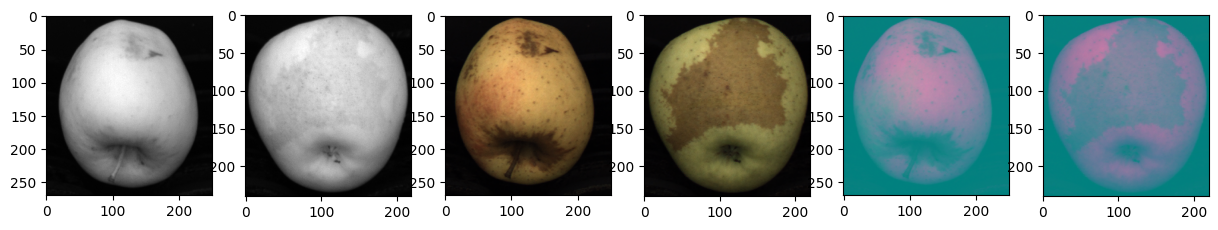

In [8]:
#create lists with the names of the images file
gray_img_names = [f'C0_00000{i}.png' for i in range(4, 6)]
colored_img_names = [f'C1_00000{i}.png' for i in range(4, 6)]
samples_names = [f'russet_{i}.png' for i in range(10)]

#create lists of the images (gray, RGB and lab version)
gray_images = [cv2.cvtColor(cv2.imread(path2 + name), cv2.COLOR_BGR2GRAY) for name in gray_img_names]
colored_images = [cv2.cvtColor(cv2.imread(path2 + name), cv2.COLOR_BGR2RGB) for name in colored_img_names]
lab = [cv2.cvtColor(cv2.imread(path2 + name), cv2.COLOR_BGR2LAB) for name in colored_img_names]

russets = [cv2.imread(path_samples + name) for name in samples_names]

all_images = gray_images + colored_images + lab

ut.visualize_imgs_array(all_images)

#### I am isolating images using the same procedure as the first task.

In [9]:
#threshold the images
threshold_images = [cv2.threshold(image, 70, 255, cv2.THRESH_BINARY)[1] for image in gray_images]

#labeling of the connected components
analysis = [cv2.connectedComponentsWithStats(image, 4, cv2.CV_32S) for image in threshold_images]

#create masks
masks = ut.create_masks(analysis, threshold_images)


#fill the holes in the masks
filled = [ut.fillhole(masks[i]) for i in range(len(masks))]

all_filled = filled + filled

#apply the mask to the corresponding fruit
isolate_fruits_gray = [cv2.bitwise_and(gray_images[i], gray_images[i], mask=filled[i]) for i in range(len(masks))]
isolate_fruits = [cv2.bitwise_and(lab[i], lab[i], mask=filled[i]) for i in range(len(masks))]

#### Mahalanobis distance

I compute the Mahalanobis distance of each pixel of the image with each russet sample, if the distance is lower than a threshold the pixel is highlighted using the white color.

<Figure size 640x480 with 0 Axes>

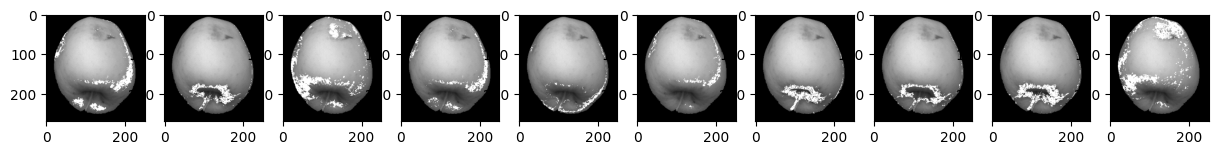

<Figure size 640x480 with 0 Axes>

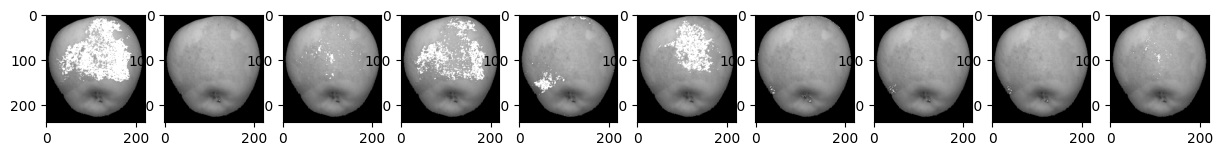

In [10]:
closest_pixels = ut.mahalanobis_distance_with_samples(russets, isolate_fruits_gray, isolate_fruits)
	
for total_image in range(len(isolate_fruits)): 
    ut.visualize_imgs_array(closest_pixels[total_image])

#### Edge detector

I use the Canny edge detector to localize the contours of the russets.

<Figure size 640x480 with 0 Axes>

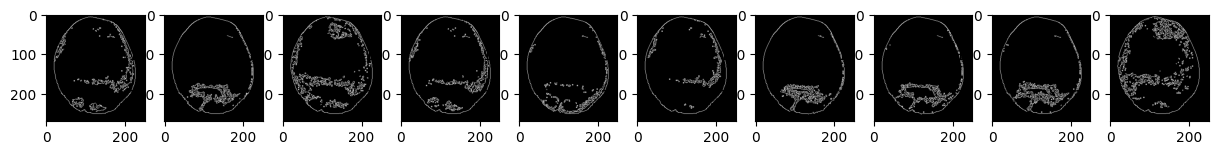

<Figure size 640x480 with 0 Axes>

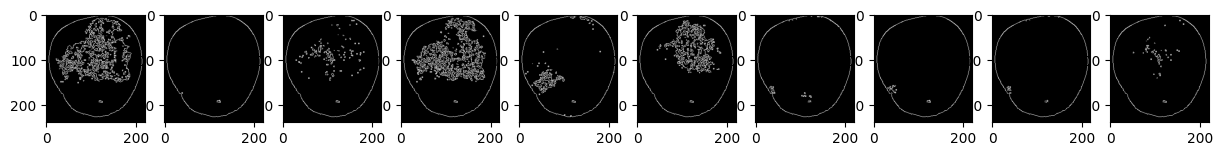

In [11]:
#apply an edge detector
edges = [[cv2.Canny(closest_pixels[total_image][i],150,200) for i in range(len(russets))] for total_image in range(len(isolate_fruits))]

#blur the images with a gaussian filter
smooth_edges = [[cv2.bilateralFilter(edges[total_image][i],9,82.9,82.9) for i in range(len(russets))] for total_image in range(len(isolate_fruits))]

for total_image in range(len(isolate_fruits)): 
    ut.visualize_imgs_array(smooth_edges[total_image])

### It's time to vote (wrote on 25 September 2022)
To do this, I have initialized a matrix of zeros of the dimension of the image, so each element of the matrix corresponds with the pixel of the image at the same position. Then for each edge image and for each pixel of that image, I increment the corresponding elements of the matrix that I create before (vote). At the end when each pixel of each image ended to vote, I can cut the false positive, so the pixel that has few votes, thanks to a threshold (2 in this case).
Then I erode function in order to divide some causal links between different zones.


<Figure size 640x480 with 0 Axes>

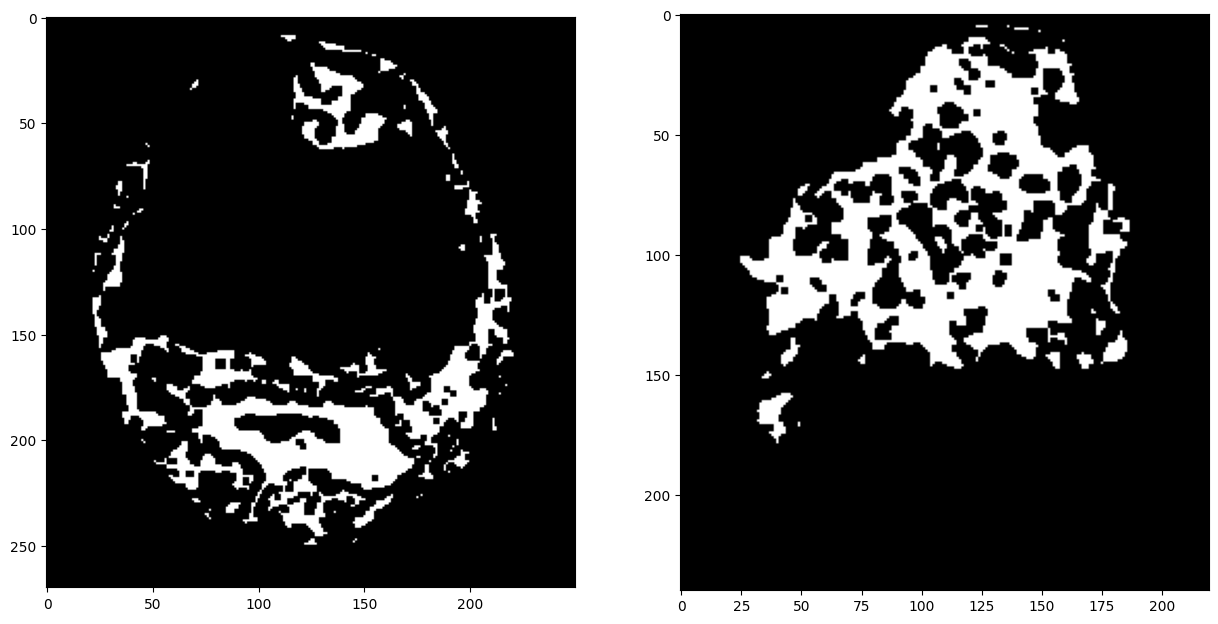

In [12]:
bins = ut.voting(isolate_fruits, smooth_edges)

#erosion
bins = [cv2.erode(bins[i],kernel,iterations = 1) for i in range(len(bins))]

ut.visualize_imgs_array(bins)

#### Compute the mask for each russet
I label each russet and then compute a mask for each of them and, then fill all the masks (same procedure as before).

<Figure size 640x480 with 0 Axes>

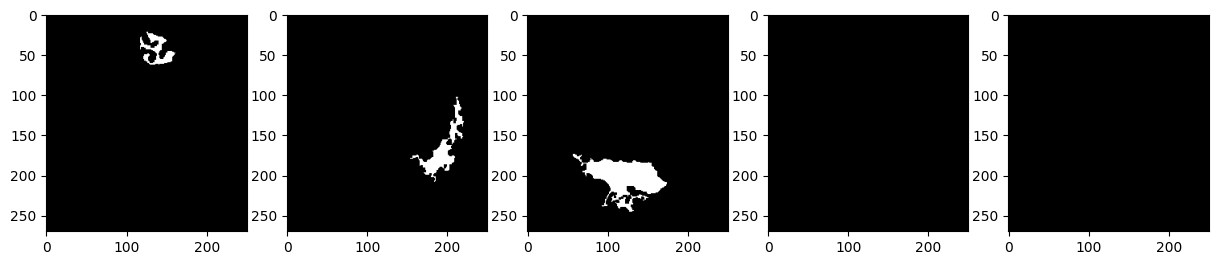

<Figure size 640x480 with 0 Axes>

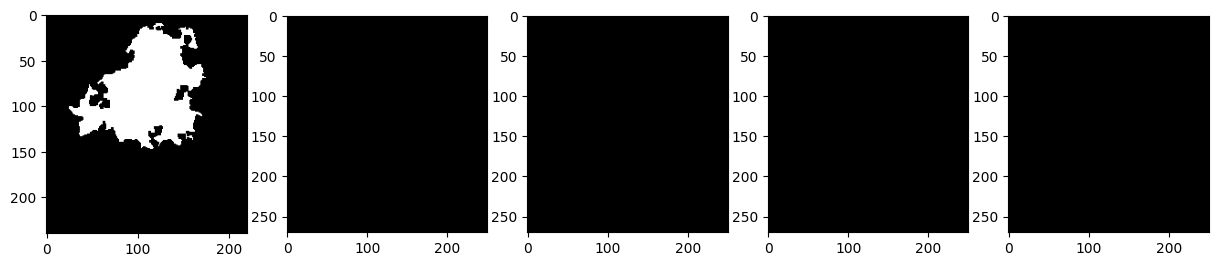

In [13]:
for i in range(len(bins)):
    bins[i] = bins[i].astype(np.uint8)

#labeling of each russet
defects_analysis = [cv2.connectedComponentsWithStats(b, 4, cv2.CV_32S) for b in bins]

#create masks
defects_masks = ut.create_defects_masks(defects_analysis, bins, 450, 20000)

#fill the holes in the masks
defects_filled = [[] for i in range(len(defects_masks))]

for i in  range(len(defects_masks)):
    defects_filled[i] = [ut.fillhole(defects_masks[i][j]) for j in range(len(defects_masks[i]))]

for i in range(len(defects_filled)):
    ut.visualize_imgs_array(defects_filled[i][:5])

### Final results
I compute the bounding box of each russet.

<Figure size 640x480 with 0 Axes>

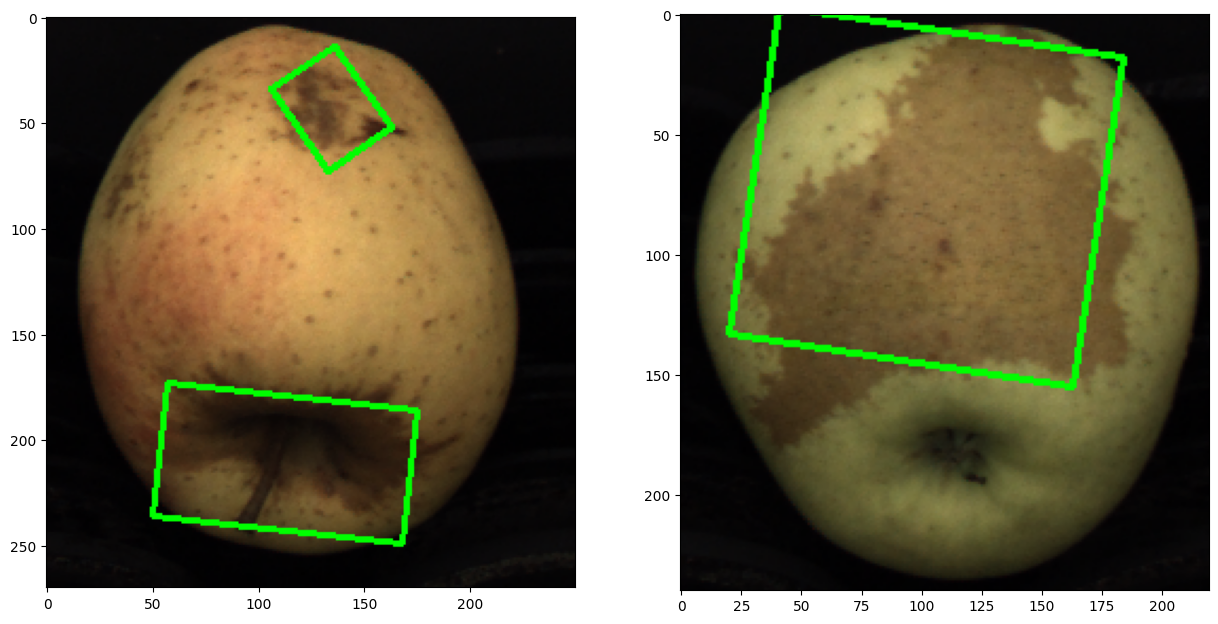

In [14]:
rect = ut.get_bbox(defects_filled, colored_images)

ut.visualize_imgs_array(rect)

# (OPTIONAL) FINAL CHALLENGE: KIWI INSPECTION

Segment the fruits and locate the defect in image “000007”. Special care should be taken to remove as 
“background” the dirt on the conveyor as well as the sticker in image “000006”.

#### Read images and images overview

<Figure size 640x480 with 0 Axes>

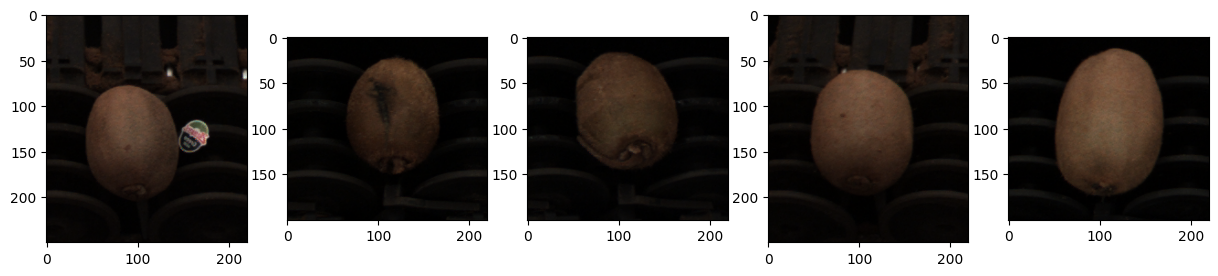

In [15]:
#create lists with the names of the images file
gray_images_names = [f'C0_00000{i}.png' for i in range(6, 10)] + ['C0_000010.png']
colored_images_names = [f'C1_00000{i}.png' for i in range(6, 10)] + ['C1_000010.png']

#create lists of the images (gray and colored version)
gray_images = [cv2.imread(path3 + name) for name in gray_images_names]
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in gray_images]
colored_images = [cv2.cvtColor(cv2.imread(path3 + name), cv2.COLOR_BGR2RGB) for name in colored_images_names]

all_images = gray_images + colored_images

ut.visualize_imgs_array(colored_images)

#### I isolate the images using the same procedure as the first task
But using OTSU to threshold the images

<Figure size 640x480 with 0 Axes>

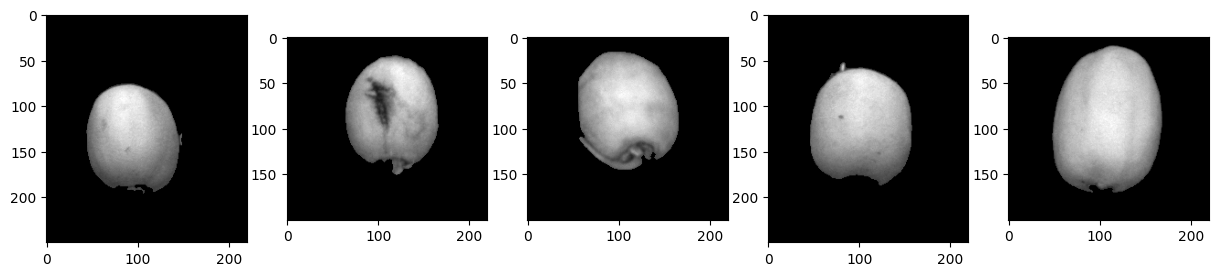

<Figure size 640x480 with 0 Axes>

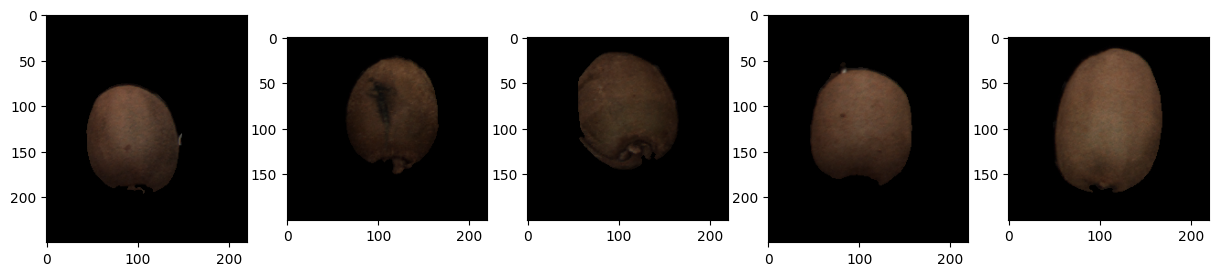

In [16]:
#blur the images
blurred_images = [cv2.GaussianBlur(image, (7, 7), 0) for image in gray_images]

#threshold images
threshold_images = [cv2.threshold(image, 40, 255, cv2.THRESH_BINARY * cv2.THRESH_OTSU)[1] for image in blurred_images]

#labeling of the connected componentss
analysis = [cv2.connectedComponentsWithStats(image, 4, cv2.CV_32S) for image in threshold_images]

#create masks
masks = ut.create_masks(analysis, threshold_images)

#fill the holes in the masks
filled = [ut.fillhole(masks[i]) for i in range(len(masks))]

all_filled = filled + filled

#apply the mask to the corresponding fruit
isolate_fruits = [cv2.bitwise_and(all_images[i], all_images[i], mask=all_filled[i]) for i in range(2*len(masks))]

ut.visualize_imgs_array(isolate_fruits[:5])
ut.visualize_imgs_array(isolate_fruits[5:])

#### Edge detector

I use the Canny edge detector to localize the contours.

<Figure size 640x480 with 0 Axes>

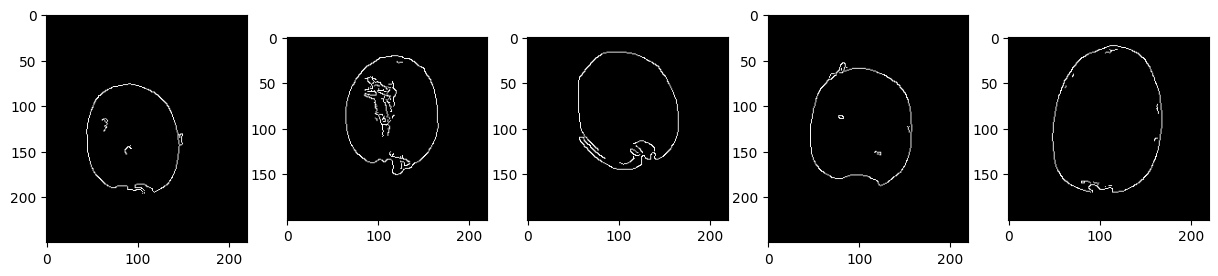

In [17]:
#apply an edge detector
edges = [cv2.Canny(isolate_fruits[i],50,100) for i in range(5)]

ut.visualize_imgs_array(edges)

### Final results
I compute the bounding box of each defect.

<Figure size 640x480 with 0 Axes>

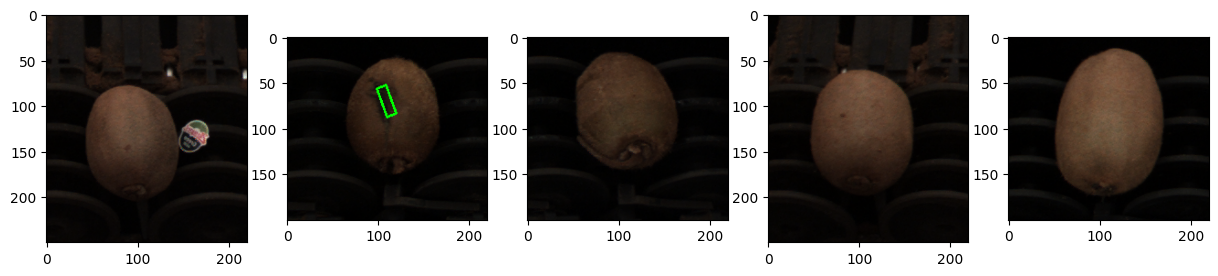

In [18]:
#labeling of each russet
defects_analysis = [cv2.connectedComponentsWithStats(e, 4, cv2.CV_32S) for e in edges]

#create masks
defects_masks = ut.create_defects_masks(defects_analysis, edges, 50, 100)

#fill the holes in the masks
defects_filled = [[] for i in range(len(defects_masks))]

for i in  range(len(defects_masks)):
    defects_filled[i] = [ut.fillhole(defects_masks[i][j]) for j in range(len(defects_masks[i]))]

#compute the bounding boxes and shows it on the images
rect = ut.get_bbox(defects_filled, colored_images)

ut.visualize_imgs_array(rect)
